# Week 4: NLP Disaster Tweets Kaggle Mini-Project

In [46]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras import layers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit


## Brief description of the problem and data (5 pts)

*Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data.*

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

*Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?*

Checking the general structure of the data and potential duplicates. 


**************************************** Train dataset ****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7613 non-null   int64 
 1   keyword     7552 non-null   object
 2   location    5080 non-null   object
 3   text        7613 non-null   object
 4   target      7613 non-null   int64 
 5   word_count  7613 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 357.0+ KB

Numerical statistics:
                  id      target   word_count
count   7613.000000  7613.00000  7613.000000
mean    5441.934848     0.42966    14.903586
std     3137.116090     0.49506     5.732604
min        1.000000     0.00000     1.000000
25%     2734.000000     0.00000    11.000000
50%     5408.000000     0.00000    15.000000
75%     8146.000000     1.00000    19.000000
max    10873.000000     1.00000    31.000

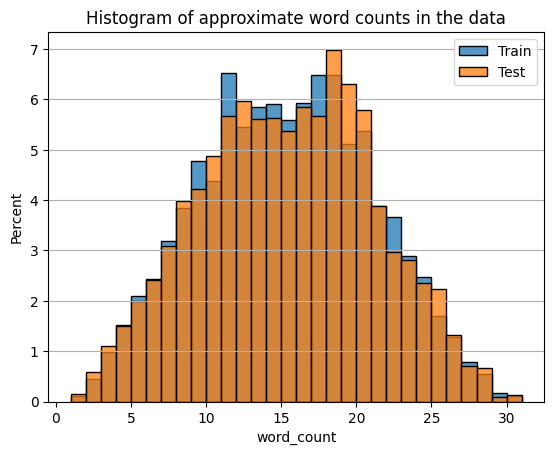

In [184]:
def count_words(df):
    for i, row in df.iterrows():
        df.loc[i, 'word_count'] = len(row.text.split())
        txt = df.loc[i, 'text']
        txt = re.sub(r'https?://\S+|www.\S+', '', txt) # Remove URLs
        txt = re.sub(r'[^a-z0-9A-Z\s]', '', txt) # Remove numbers
        # txt = txt.lower()
        df.loc[i, 'text'] = txt
    df['word_count'] = df['word_count'].astype(int)
    all_text = ' '.join(df.text)
    unique_words = len(set(all_text.split()))
    return unique_words

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_unique_words = count_words(train_df)
test_unique_words = count_words(test_df)

all_text = ' '.join(((pd.concat([train_df,test_df], axis=0)).text.values))
all_unique_words = len(set(all_text.split()))


print('\n' + 40*'*' + ' Train dataset ' + 40*'*')
train_df.info()
print('\nNumerical statistics:\n', train_df.describe())
print('\n', train_df.head(4), '\n')
# print('\n', train_df.tail(3))
print('Number of duplicated rows:', np.sum(train_df.duplicated()))
print('Number of duplicated texts:', np.sum(train_df.duplicated(subset='text')))
print('Longest tweet has', np.max(train_df.word_count), 'words.')
print('Unique words in the dataset:', train_unique_words)
print('Target values:', pd.unique(train_df.target))
y_split = round(100 * np.sum(train_df.target == 1)/len(train_df.target))
print('Target split: \n1 (disaster) =', y_split, '%\n0 (not disaster) =', 100-y_split, '%')

print('\n' + 40*'*' + ' Test dataset ' + 40*'*')
test_df.info()
print('\nNumerical statistics:\n', test_df.describe())
print('\n', test_df.head(4), '\n')
# print('\n', test_df.tail(3))
print('Number of duplicated rows:', np.sum(test_df.duplicated()))
print('Number of duplicated texts:', np.sum(test_df.duplicated(subset='text')))
print('Longest tweet has', np.max(test_df.word_count), 'words.')
print('Unique words in the dataset:', test_unique_words)


sns.histplot(train_df, x='word_count', bins=30, stat='percent')
sns.histplot(test_df, x='word_count', bins=30, stat='percent')
plt.grid(axis='y')
plt.title('Histogram of approximate word counts in the data')
plt.legend(['Train','Test'])
plt.show()

Remove duplicates from the training set

In [108]:
print('Size with duplicated texts:', len(train_df))
train_df.drop_duplicates(subset='text', inplace=True)
print('Size without duplicated texts:', len(train_df))

Size with duplicated texts: 7613
Size without duplicated texts: 6961


## Model Architecture (25 pts)

*Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem.*

*Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.*

*There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.*

*Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.).*

### Text to matrix

In [4]:
maxlen = 300
max_features = 10000

In [20]:
my_vectorizer = keras.layers.TextVectorization(
    max_tokens=max_features,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    ngrams=2,
    output_mode="int",
    output_sequence_length=None,
    pad_to_max_tokens=None,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False,
    encoding="utf-8",
    name=None,
)
my_vectorizer.adapt(train_df['text'])
x_train = my_vectorizer(train_df['text'])

x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
# x_test = keras.utils.pad_sequences(x_test, maxlen=maxlen)
y_train = train_df.target

print('Shape:', x_train.shape)
print('Min and max:', np.min(x_train), np.max(x_train))

Shape: (6961, 300)
Min and max: 0 9999


In [43]:
train_df.loc[:,['text','keyword','location']]

,text,keyword,location
0,Our Deeds are the Reason of this earthquake Ma...,NaN,NaN
1,Forest fire near La Ronge Sask Canada,NaN,NaN
2,All residents asked to shelter in place are be...,NaN,NaN
3,13000 people receive wildfires evacuation orde...,NaN,NaN
4,Just got sent this photo from Ruby Alaska as s...,NaN,NaN
...,...,...,...
7602,a siren just went off and it wasnt the Forney ...,NaN,NaN
7603,Officials say a quarantine is in place at an A...,NaN,NaN
7604,WorldNews Fallen powerlines on Glink tram UPDA...,NaN,NaN
7605,on the flip side Im at Walmart and there is a ...,NaN,NaN


In [ ]:
# my_vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.95, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
# my_vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.95, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 1), stop_words='english')
# my_vectorizer = TfidfVectorizer(sublinear_tf=True)
my_vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.95, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english', max_features=max_features)
my_vectorizer.fit(train_df.text)
x_data = my_vectorizer.transform(train_df['text'])
x_train = x_data
y_train = train_df.target

print('Shape of x_train:', x_train.shape)
print('Shape of y_train:', y_train.shape)

ftr_names = my_vectorizer.get_feature_names_out()
print('Length of ftr_names:',len(ftr_names))
print('ftr_names:', my_vectorizer.get_feature_names_out())

x_test = my_vectorizer.transform(test_df['text'])
print('Shape of X_test:', x_test.shape)


Shape of x_train: (6961, 2825)
Shape of y_train: (6961,)
Length of ftr_names: 2825
ftr_names: ['05' '06' '10' ... 'yyc' 'zombie' 'zone']
Shape of X_test: (3263, 2825)


<generator object BaseShuffleSplit.split at 0x0000021BC12C6740>

### Use Tensor Flow data sets

In [185]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df.text.values, train_df.target.values))
test_ds =  tf.data.Dataset.from_tensor_slices((test_df.text.values))
all_txt = pd.concat([train_df.text, test_df.text], axis=0)
train_test_ds = tf.data.Dataset.from_tensor_slices((all_txt.values))


In [186]:
for txt in test_ds.take(5):
    tf.print(txt.numpy()[ :50])
for txt, trg in train_ds.take(5):
    tf.print(trg, '\t', txt.numpy()[ :50])
for txt in train_test_ds.take(5):
    tf.print(txt.numpy()[ :50])

b'Just happened a terrible car crash'
b'Heard about earthquake is different cities stay sa'
b'there is a forest fire at spot pond geese are flee'
b'Apocalypse lighting Spokane wildfires'


b'Typhoon Soudelor kills 28 in China and Taiwan'
1 	 b'Our Deeds are the Reason of this earthquake May AL'
1 	 b'Forest fire near La Ronge Sask Canada'
1 	 b'All residents asked to shelter in place are being '
1 	 b'13000 people receive wildfires evacuation orders i'
1 	 b'Just got sent this photo from Ruby Alaska as smoke'
b'Our Deeds are the Reason of this earthquake May AL'
b'Forest fire near La Ronge Sask Canada'
b'All residents asked to shelter in place are being '
b'13000 people receive wildfires evacuation orders i'
b'Just got sent this photo from Ruby Alaska as smoke'


In [187]:
text_count = len(train_df)
val_size = int(text_count * 0.2)
print('Validation size:', val_size)
train_ds = train_ds.shuffle(text_count, reshuffle_each_iteration=False)
val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)


Validation size: 1522


In [188]:
all_unique_words

# Initialize the tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=all_unique_words, split=' ', oov_token='<OOV>')

# Fit the tokenizer on the sentences
tokenizer.fit_on_texts(all_txt)

word_index = tokenizer.word_index
print(word_index['a'])

sequences = tokenizer.texts_to_sequences(all_txt)
print(len(sequences))

padded_sequences = keras.preprocessing.sequence.pad_sequences(sequences, padding='post')
print(padded_sequences.shape)


3
10876
(10876, 31)


In [189]:
word_index['hello']

1703

In [191]:
def encode_train(text_tensor, label):
    text = text_tensor.numpy()[0]
    encoded_text =  tokenizer.texts_to_sequences(text)
    return encoded_text, label

def encode_test(text_tensor):
    text = text_tensor.numpy()[0]
    encoded_text =  tokenizer.texts_to_sequences([text])
    return encoded_text

def encode_map_fn_train(text, label):
    return tf.py_function(encode_train, inp=[text, label], Tout=(tf.int64, tf.int64))

def encode_map_fn_test(text):
    return tf.py_function(encode_test, inp=[text], Tout=(tf.int64))

def _fixup_shape(text, label):
    text.set_shape([])
    label.set_shape([])
    return text, label

def _fixup_test_shape(text):
    text.set_shape([])
    return text

# train_ds = train_ds.map(encode_map_fn_train)
# val_ds = val_ds.map(encode_map_fn_train)
test_ds = test_ds.map(encode_map_fn_test)
# test_ds = test_ds.map(_fixup_test_shape)
test_ds = test_ds.padded_batch(32, padded_shapes=([-1]))


In [192]:
for txt in test_ds.take(5):
    tf.print(txt.numpy()[ :50])

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} Error in user-defined function passed to MapDataset:771 transformation with iterator: Iterator::Root::Prefetch::FiniteTake::PaddedBatchV2::Map::PaddedBatchV2::Map: AttributeError: 'int' object has no attribute 'lower'
Traceback (most recent call last):

  File "C:\Users\nikok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tensorflow\python\ops\script_ops.py", line 267, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\nikok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tensorflow\python\ops\script_ops.py", line 145, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\nikok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tensorflow\python\ops\script_ops.py", line 152, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "C:\Users\nikok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\nikok\AppData\Local\Temp\ipykernel_51080\1837237296.py", line 8, in encode_test
    encoded_text =  tokenizer.texts_to_sequences([text])
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\nikok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\legacy\preprocessing\text.py", line 177, in texts_to_sequences
    return list(self.texts_to_sequences_generator(texts))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\nikok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\legacy\preprocessing\text.py", line 192, in texts_to_sequences_generator
    seq = text_to_word_sequence(
          ^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\nikok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\legacy\preprocessing\text.py", line 22, in text_to_word_sequence
    input_text = input_text.lower()
                 ^^^^^^^^^^^^^^^^

AttributeError: 'int' object has no attribute 'lower'


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

In [118]:
print("Example Sequences and their length:\n")
example = train_ds.take(8)
for ex in example:
    print(f"Individual Size: {ex[0].shape}")
print("Batched examples and the sequence length:\n")
batched_example = example.padded_batch(4, padded_shapes=([-1], []))
for batch in batched_example:
    print(f"Batch dimension: {batch[0].shape}")

Example Sequences and their length:



InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Error in user-defined function passed to MapDataset:663 transformation with iterator: Iterator::Root::Prefetch::FiniteTake::Map::Map: TypeError: 'int' object is not iterable
Traceback (most recent call last):

  File "C:\Users\nikok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tensorflow\python\ops\script_ops.py", line 267, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\nikok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tensorflow\python\ops\script_ops.py", line 145, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\nikok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tensorflow\python\ops\script_ops.py", line 152, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "C:\Users\nikok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\nikok\AppData\Local\Temp\ipykernel_51080\4172475293.py", line 3, in encode_train
    encoded_text =  tokenizer.texts_to_sequences(text)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\nikok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\legacy\preprocessing\text.py", line 177, in texts_to_sequences
    return list(self.texts_to_sequences_generator(texts))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\nikok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\legacy\preprocessing\text.py", line 182, in texts_to_sequences_generator
    for text in texts:
                ^^^^^

TypeError: 'int' object is not iterable


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

In [ ]:
train_ds = train_ds.padded_batch(32, padded_shapes=([-1], []))
tweets_valid = tweets_valid.padded_batch(32, padded_shapes=([-1], []))
tweets_unseen_batched = tweets_unseen_map.padded_batch(32, padded_shapes=([-1], []))

### Model building

#### LSTM

In [116]:
# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
# Add 2 LSTMs
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128)(x)
# Add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, None, 128)      │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,674,881 (6.39 MB)

 Trainable params: 1,674,881 (6.39 MB)

 Non-trainable params: 0 (0.00 B)

#### Bi-directional LSTM

In [7]:
# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
# Add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 128)      │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 128)      │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,037,761 (15.40 MB)

 Trainable params: 4,037,761 (15.40 MB)

 Non-trainable params: 0 (0.00 B)

#### GRU

In [73]:
# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
# Add 2 LSTMs
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.GRU(64, return_sequences=True)(x)
x = layers.GRU(64)(x)
# Add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_17 (Embedding)        │ (None, None, 128)      │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, None, 64)       │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 382,273 (1.46 MB)

 Trainable params: 382,273 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
## https://www.kaggle.com/code/anmolstha/disaster-tweets-simple-rnn-implementation
# Long Short Term Memory network.

# We need sequential model to process sequence of text data
model = keras.models.Sequential()

# Embedding(input_dimension, output_dimension,embeddings_initializer = initialize the embedding matrix we created, trainable = do not train)
embedding= layers.Embedding(max_features, 100, trainable=False)
# Adding Embedding Layer
model.add(embedding)

# Drops 40% of entire row
model.add(layers.SpatialDropout1D(0.4))

# Recurrent Layer LSTM(dimensionality of the output space, dropout = 20%, recurrent_dropout = 20%) 
model.add(layers.GRU(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(layers.GRU(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(layers.GRU(64, dropout=0.2, recurrent_dropout=0.2))

# Decide what we are going to output Dense(units, activation function)
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model compile(loss = binary crossentropy, use Adam(adaptive moment estimation) optimizer with learning rate 1e-3,evaluate based on accuracy)
model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Model training

max length = 1000

3rd layer 0.5391

256 dim 0.5391




In [32]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.2)

Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 39s 399ms/step - accuracy: 0.5992 - loss: 0.6752 - val_accuracy: 0.5686 - val_loss: 0.6847
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 34s 388ms/step - accuracy: 0.5948 - loss: 0.6755 - val_accuracy: 0.5686 - val_loss: 0.6836
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 33s 385ms/step - accuracy: 0.5990 - loss: 0.6731 - val_accuracy: 0.5686 - val_loss: 0.6818
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 35s 400ms/step - accuracy: 0.5983 - loss: 0.6735 - val_accuracy: 0.5686 - val_loss: 0.6818
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 38s 442ms/step - accuracy: 0.5928 - loss: 0.6739 - val_accuracy: 0.5686 - val_loss: 0.6856


In [117]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train_ds, batch_size=32, epochs=1, validation_data=val_ds)


ValueError: as_list() is not defined on an unknown TensorShape.

In [33]:
history.history


{'accuracy': [0.5957255959510803,
  0.5957255959510803,
  0.5957255959510803,
  0.5957255959510803,
  0.5957255959510803],
 'loss': [0.6757225394248962,
  0.6749722361564636,
  0.6746339201927185,
  0.6741043329238892,
  0.6740113496780396],
 'val_accuracy': [0.56855708360672,
  0.56855708360672,
  0.56855708360672,
  0.56855708360672,
  0.56855708360672],
 'val_loss': [0.6847301721572876,
  0.68359375,
  0.6818068027496338,
  0.681846559047699,
  0.6856157779693604]}

## Results and Analysis (35 pts)

*Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.*

*Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.*



## Conclusion (15 pts)

*Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?*



# Sources
https://keras.io/examples/nlp/bidirectional_lstm_imdb/
